# Running simulations of the Foraging Ascomycete Model

<a id='contents'></a>
### contents

[Setup](#setup)  
[Survival of the lonely? dispersal of one fungus.](#onefungus)

Let's try some parameter sweeps with our new model. First, let's compare what happens when two fungi vary in their ability to disperse spores across the landscape, without any endophytic abilites. Our parameter sweep file will look like this:

<a id='setup'></a>

In [ ]:
from FAmodel import Forest
from FAmodel import sumendos
from FAmodel import sumdecomps
from FAagents import Tree, Wood, Fungus
import numpy as np
import matplotlib.pyplot as plt
import thomasprocess as tp
import pickle
%matplotlib inline

[back to contents](#contents)

<a id='onefungus'></a>

## Survival of the...only?

For our first parameter sweep, let's see what it takes to get established, and persist, as a decomposer fungus new to a recent area of wind-fall. To model this, we keep the model defaults of a fair amount of initial wood present on the landscape (ws = 30), and then a steady, lower rate of wood deposition from this point on. A blue fungus will appear in the beginning of the model but have no ability to disperse, so they won't expand beyond the initial log that they occupy.  

In [27]:
endo_runs = {}
decomp_runs = {}
for i in [ a/2 for a in range(0,21,1) ]: ## levels of variable
    endo_list = []
    decomp_list = []
    for j in range(100): ## number of simulations per level of parameter
        losced = Forest(endophytism = False, ##settings for model
                        ws = 30,
                        endodisp = 0,
                        decompdisp=i, ## parameter of interest
                        )
        for j in range(50): losced.step() ## number of steps before ending the model
        ## data into lists
        endo_list.append(losced.datacollector.get_model_vars_dataframe().Endophytes)
        decomp_list.append(losced.datacollector.get_model_vars_dataframe().Decomposers)
    endo_runs[i] = endo_list
    decomp_runs[i] = decomp_list


In [ ]:
#pickle.dump(blue_runs, open('blue_runs.p', 'wb'))`
#pickle.dump(red_runs, open('red_runs.p', 'wb'))

In [2]:
blue_runs = pickle.load(open('blue_runs.p', 'rb'))
red_runs = pickle.load(open('red_runs.p', 'rb'))

There aren't any endophytes in this scenario. When there are endophyte-capable fungi, we assign them blue, some of the above code reflects this. To visualize a run:

In [3]:
def plot_run(level):
    for i in zip(blue_runs[level], red_runs[level]): ## alternate ('zip') between to make sure both are visible
        plt.plot([ j for j in range(50) ], i[0]+0.1, c='b') ## lift one set (blue) up a little to increase visibility.
        plt.plot([ j for j in range(50) ], i[1], c='r')

As a second parameter sweep, let's compare two non-endophyte decomposers, holding one fungus' dispersal capability constant at the model default of 1.0 (plus all other parameters at model defaults, and varying the other. The goal is to get a feel for how competitive the system is: what level of dispersal does it take to survive on the landscape we have created.

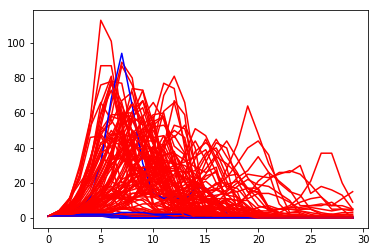

In [21]:
plot_run(10)

Works. But if we want to plot all the runs, from each level of the parameter sweep:

ValueError: x and y must have same first dimension, but have shapes (50,) and (30,)

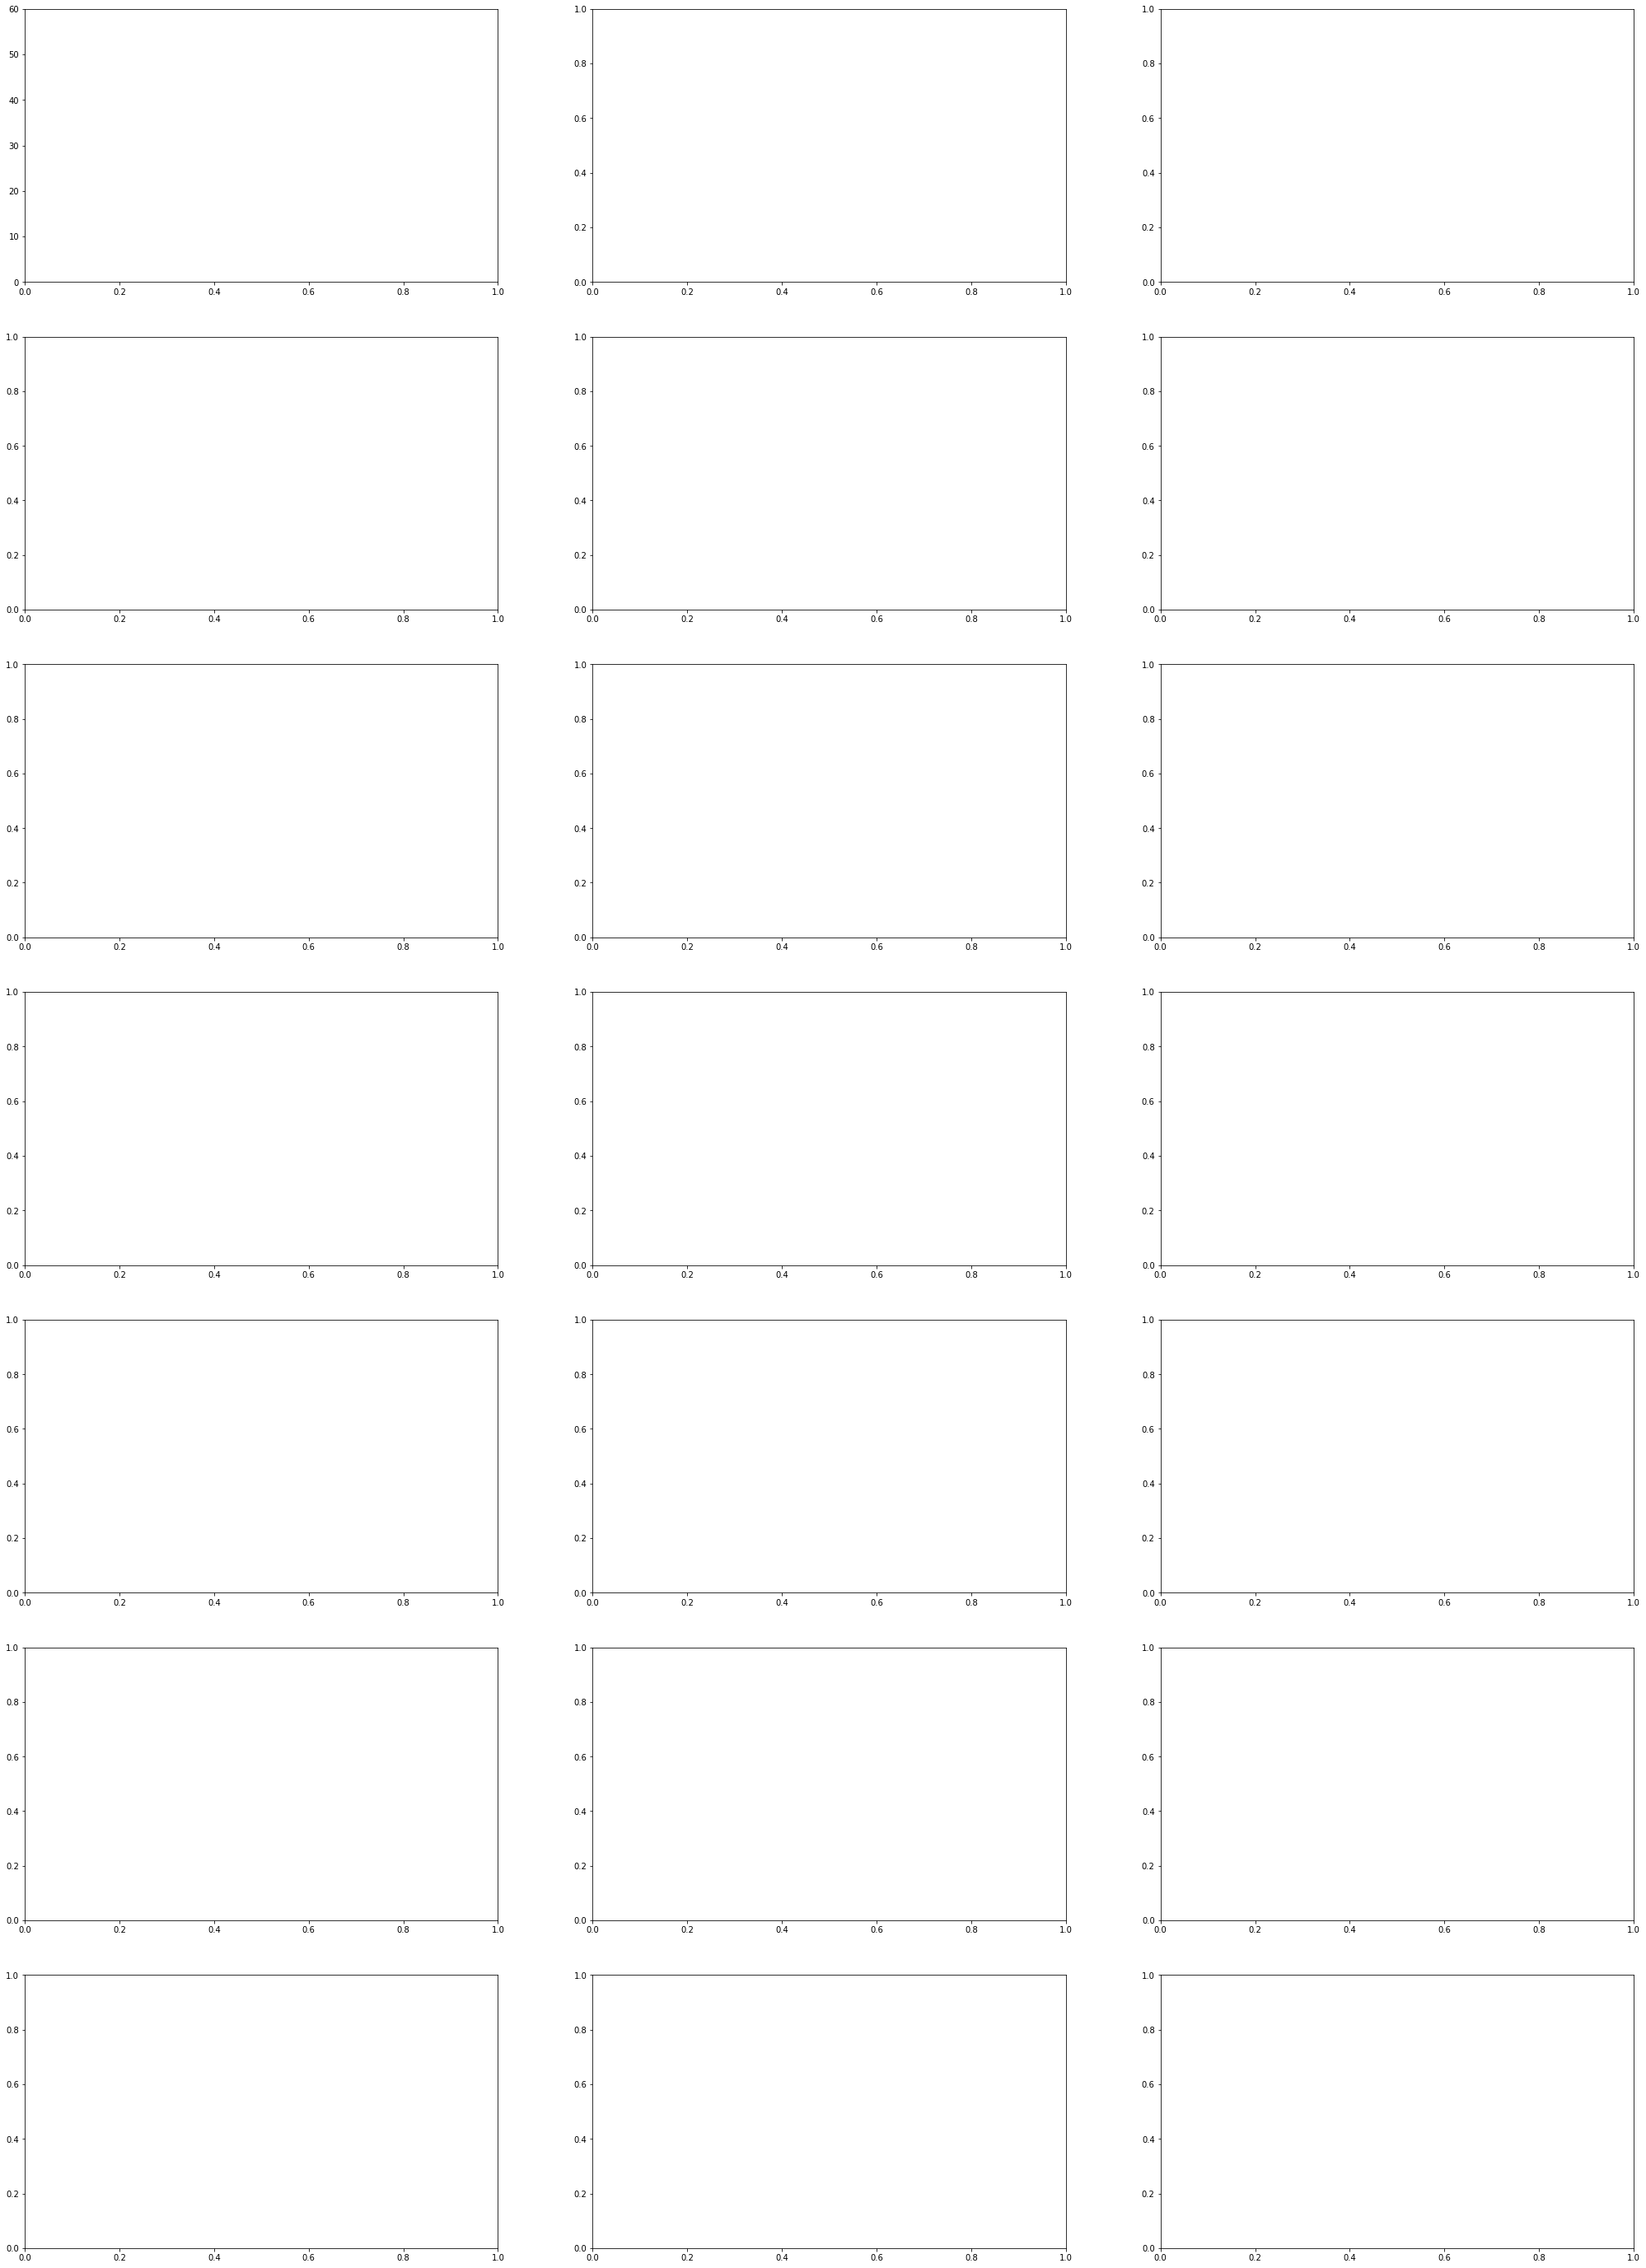

In [20]:
fig, axes = plt.subplots(7,3, figsize=(35, 50)) ## set figure, nrows and ncols, sizes
lvls = sorted(list(blue_runs.keys())) ## levels of the run, should be same as...
lvls2 = sorted(list(red_runs.keys())) ## don't need but might be useful check
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    for j in red_runs[lvls[i]]: ## plot all of our red fungi of a given level
        z.set_ylim([0, 60])
        z.plot([ h for h in range(50) ], j, c='r')
        z.text(.95, .9, 'disp=%s' % lvls[i],
                color='r',
                size='20',
                horizontalalignment='right',
                verticalalignment='top',
                transform=z.transAxes)
    for j in blue_runs[lvls[i]]: ## plot our blue fungi next. 
        z.plot([ h for h in range(50) ], j, c='b')


[back to contents](#contents)